In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext
sc = SparkContext("local", "first app")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

#### 데이터셋 생성

In [4]:
def create_setdata(ss):
    record = set()
    for i in ss:
        if i not in record:
            record.add(i)
        else:
            yield record
            record = set()
    if not record:
        yield record

In [5]:
def create_dataset(N):
    """
    N개의 집합 데이터 생성 (D = 사전 사이즈)
    """
    
    while True:
        s = np.random.default_rng().zipf(1.2, N*10*10)
        dataset = list(create_setdata(s[s<N]))
        if len(dataset) >= N:
            break
        
    ids = range(N)
    return [(i, s) for i, s in zip(ids, dataset[:N])]

#### Destination의 id에 따라 블럭 지정

In [6]:
def pr_map(t, block):
    result = []
    for target in t[1]:
        block_id = int(target / int(20000/block))
        yield(block_id, (target, (pr.value[t[0]] / len(t[1]))))

#### 해당 인덱스에 값 업데이트

In [7]:
def pr_red(t, block):
    
    block_id, it = t
    B_height = int(20000/block)
    
    D = [0 for i in range(20000)]
    pr = [0 for i in range(20000)]
    
    for dest, prob in it:
        D[dest] += prob

    for B_idx in range(B_height):
        i = B_idx + block_id * B_height
        pr[i] = (0.85*D[i]) + (1/20000 * (1-0.85))
        yield((i, pr[i]))

In [8]:
block = [16, 8, 4, 2, 1]
maxIter = 20

In [9]:
dataset = create_dataset(20000)

In [10]:
result = []

In [13]:
for b in block:
    start = time.time()
    
    inputRDD = sc.parallelize(dataset)
    pr = sc.broadcast([ 1. / float(20000) for _ in range(20000) ])
    
    for _ in range (maxIter):
        itr = inputRDD.flatMap(lambda t: pr_map(t, b)).groupByKey()\
                      .flatMap(lambda t: pr_red(t, b)).map(lambda v: v[1]).collect()
        pr = sc.broadcast(itr)
       
    end = time.time()
    duration = end - start
    result.append(end-start)
    
    
    print("# of block : {}".format(b))
    print("duration : {}".format(duration))
    print()

# of block : 16
duration : 44.45093488693237

# of block : 8
duration : 40.66400098800659

# of block : 4
duration : 42.10488748550415

# of block : 2
duration : 40.16887283325195

# of block : 1
duration : 40.32513880729675



#### 그래프

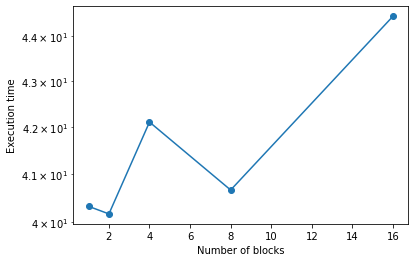

In [16]:
plt.plot(block, result, marker = 'o')
plt.xlabel("Number of blocks")
plt.ylabel("Execution time")

plt.yscale('log')
plt.show()